# Runs the Heat Pump Model for Multiple Scenaries across Multiple Communities

In [1]:
import sys
import numpy as np
import pandas as pd

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

#---- Auto-reload of modules
%load_ext autoreload
%autoreload 2

#---- Altair imports 
import altair as alt
alt.data_transformers.enable('json');   # keeps Huge data out of Notebook

## Loop through Cities Running all Scenarios

In [2]:
# Import heat pump calculation model and library

import heatpump.library as lib
import heatpump.hp_model as hpmod

acquiring library data...


In [3]:
# Base Case Inputs to the Heat Pump Calcuator.
in_base = dict(
    bldg_name='Test',
    notes='',
    pce_limit=500,
    co2_lbs_per_kwh=1.5,
    exist_fuel_use=None,
    elec_uses='all',
    exist_heat_effic=0.8,
    exist_kwh_per_mmbtu=6.25,
    includes_dhw=False,
    includes_dryer=False,
    includes_cooking=False,
    occupant_count=3,
    hp_model_id=-1,
    low_temp_cutoff=5,
    off_months_chks=[],
    garage_stall_count=1,
    garage_heated_by_hp=False,
    indoor_heat_setpoint=70,
    insul_level=2,
    pct_exposed_to_hp=0.46,
    doors_open_to_adjacent=True,
    bedroom_temp_tolerance='med',
    rebate_dol=0,
    pct_financed=0,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=0,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

Inputs that need to be determined for each community: `city_id`, `utility`, `bldg_floor_area`, `exist_heat_fuel_id`, `exist_unit_fuel_cost`, `elec_use_jan`, `elec_use_may`, `capital_cost`, `sales_tax` 

In [4]:
in_test = in_base.copy()
in_test['city_id'] = 1
in_test['utility'] = lib.util_from_id(53)
in_test['bldg_floor_area'] = 1700
in_test['exist_heat_fuel_id'] = 4     # 4 - #1 Oil, 3 - Propane, 1 - Electricity
in_test['exist_unit_fuel_cost'] = 2.69
in_test['elec_use_jan'] = 674
in_test['elec_use_may'] = 503
in_test['capital_cost'] = 4000
in_test['sales_tax'] =  0.06

In [5]:
mod = hpmod.HP_model(**in_test)
mod.run()
mod.summary

{'fuel_unit': 'gallon',
 'fuel_desc': '#1 Oil',
 'design_heat_load': 22236.560640000003,
 'design_heat_temp': 9.8,
 'cop': 2.4913062598640576,
 'hp_max_capacity_5F': 11978.4231,
 'max_hp_reached': True,
 'co2_lbs_saved': 2023.4734949235353,
 'co2_driving_miles_saved': 2268.801242024934,
 'hp_load_frac': 0.7541051733186053,
 'irr': -0.6154427774133946,
 'npv': -5273.637979397903,
 'fuel_use_base': 797.1160334938629,
 'fuel_use_hp': 199.14230801805363,
 'fuel_use_chg': -597.9737254758093,
 'fuel_price_incremental': 2.8514000000000004,
 'elec_use_base': 6567.6264532423575,
 'elec_use_hp': 14057.097464709657,
 'elec_use_chg': 7489.4710114673,
 'elec_rate_avg_base': 0.2956720351619492,
 'elec_rate_avg_hp': 0.27503419941529333,
 'elec_rate_incremental': 0.2569365799999999}

In [7]:
# Maps Census Area to average size of home.  Comes from the 2018 AHFC
# Housing Assessment.
census_to_size = {
 'Anchorage municipality': 2057,
 'Aleutians West Census Area': 1130,
 'Aleutians East Borough': 1296,
 'Yukon-Koyukuk Census Area': 947,
 'Hoonah-Angoon Census Area': 1258,
 'Bethel Census Area': 950,
 'Juneau City and Borough': 1725,
 'North Slope Borough': 1164,
 'Southeast Fairbanks Census Area': 1745,
 'Matanuska-Susitna Borough': 1912,
 'Denali Borough': 1736,
 'Lake and Peninsula Borough': 1026,
 'Valdez-Cordova Census Area': 1781,
 'Prince of Wales-Hyder Census Area': 1246,
 'Kenai Peninsula Borough': 1890,
 'Northwest Arctic Borough': 920,
 'Nome Census Area': 1168,
 'Wade Hampton Census Area': 834,
 'Dillingham Census Area': 1150,
 'Bristol Bay Borough': 1445,
 'Haines Borough': 1730,
 'Yakutat City and Borough': 1116,
 'Skagway Municipality': 1672,
 'Sitka City and Borough': 1629,
 'Wrangell City and Borough': 1766,
 'Petersburg Borough': 1714,
 'Ketchikan Gateway Borough': 1734,
 'Kodiak Island Borough': 1790,
 'Fairbanks North Star Borough': 2068,
}

In [9]:
fuel_override = {}
block1_rate_override = {}
pce_override = {}

def check_elec_override(util):
    """'util' is a Utility series and it is adjusted if one of the
    above overrides applies.
    """
    ut = util.copy(deep=True)
    if ut['Name'] in block1_rate_override:
        kwh_limit, rate = ut.Blocks[0]
        blocks = ut.Blocks.copy()
        blocks[0] = (kwh_limit, block1_rate_override[ut['Name']])
        ut.Blocks = blocks
        
    if ut['Name'] in pce_override:
        ut.PCE = pce_override[ut['Name']]
        
    return ut        

In [10]:
def find_res_util(city):
    """Returns the first residential electric utility for the city, or None
    if no Residential utility exists.
    """
    for _, util_id in city.ElecUtilities:
        util = lib.util_from_id(util_id)
        if not util.IsCommercial:
            return check_elec_override(util)
    return None

def find_sm_comm_util(city):
    """Returns the small commercial utilty for the city, resorting to the 
    only utility if there are no commercial utilities.
    """
    comm_utils = []    # list of commercial utilities
    for _, util_id in city.ElecUtilities:
        util = lib.util_from_id(util_id)
        if util.IsCommercial:
            comm_utils.append(util)
            if np.nan_to_num(util.DemandCharge)==0.0 or 'sm' in util.Name.lower():
                return check_elec_override(util)
    if len(comm_utils) > 0:
        # Assume first commercial utility is the small commercial rate schedule 
        return check_elec_override(comm_utils[0])
    else:
        # Return the first utility
        _, util_id = city.ElecUtilities[0]
        return check_elec_override(lib.util_from_id(util_id))
    return None
    
def scenarios(city_id, fuel_id):
    '''Returns a list of (scenario name, input dictionary) tuples for all 
    of the scenarios being modeled for 'city_id' with the existing system
    using 'fuel_id'.
    '''
    scenarios = []
    city = lib.city_from_id(city_id)
    
    # ------------------- Base Case Scenario
    
    sc_base = in_base.copy()
    sc_base['city_id'] = city_id
    sc_base['exist_heat_fuel_id'] = fuel_id
    
    # If electric heat, then 100% efficient
    if fuel_id == 1:
        sc_base['exist_heat_effic'] = 1.0

    # Capital Cost
    # Each cost level is the same percentage above the one prior.
    # Assume highest level (level 5) is 1.6 x lowest level.
    cost_mult = 1.6 ** 0.25
    sc_base['capital_cost'] = 4000.0 * cost_mult ** (city.ImprovementCostLevel - 1)
    
    # Find the residential utility for this city
    sc_base['utility'] = find_res_util(city)
    
    # Building Floor Area
    sc_base['bldg_floor_area'] = census_to_size[city.census_area]
    
    # fuel price
    if fuel_id != 1:
        # Not Electricity
        if (city.Name, fuel_id) in fuel_override:
            # Override exists for fuel price
            sc_base['exist_unit_fuel_cost'] =  fuel_override[(city.Name, fuel_id)]
        else:
            the_fuel = lib.fuel_from_id(fuel_id)
            price_col = the_fuel['price_col']
            price = np.nan_to_num(city[price_col])
            sc_base['exist_unit_fuel_cost'] = price
    else:
        sc_base['exist_unit_fuel_cost'] = np.nan
        
    # January and May electricity use
    sc_base['elec_use_jan'] = city.avg_elec_usage[0]
    sc_base['elec_use_may'] = city.avg_elec_usage[4]
    
    # Sales Tax
    sc_base['sales_tax'] = np.nan_to_num(city.MunicipalSalesTax) + np.nan_to_num(city.BoroughSalesTax)
    
    scenarios.append(('Base', sc_base))
    
    # --------------------- Small Load Scenario
    
    sc_small = sc_base.copy()
    # 40% smaller floor area
    sc_small['bldg_floor_area'] *= 0.6      
    
    # 20% reduction in base electric use
    sc_small['elec_use_jan'] *= 0.8
    sc_small['elec_use_may'] *= 0.8
    
    # Toyostove or Rinnai type efficiency and auxiliary use
    if fuel_id == 4:
        sc_small['exist_heat_effic'] = 0.84
    elif fuel_id == 3 or fuel_id==2:
        sc_small['exist_heat_effic'] = 0.82
    sc_small['exist_kwh_per_mmbtu'] = 3.0
    
    scenarios.append(('Small Load', sc_small))
    
    # --------------------- Large Load Scenario

    sc_large = sc_base.copy()
    # 50% larger floor area
    sc_large['bldg_floor_area'] *= 1.5      
    
    # Trying to make this a heat pump favorable scenario, so leave base
    # electric use the same.
    
    # Lower non-electric efficiencies, higher auxiliary use
    if fuel_id != 1:
        sc_large['exist_heat_effic'] = 0.77
        sc_large['exist_kwh_per_mmbtu'] = 9.0
    
    scenarios.append(('Large Load', sc_large))
    
    # -------------------- Base Case with Low Base Electricity Use
    # This only affects PCE communities, so only do it there.
    util = sc_base['utility']
    if (util is not None) and np.nan_to_num(util.PCE) > 0.0:
    
        sc_low_elec = sc_base.copy()

        # 30% reduction in base electric use
        sc_low_elec['elec_use_jan'] *= 0.7
        sc_low_elec['elec_use_may'] *= 0.7

        scenarios.append(('Low Elec', sc_low_elec))
        
        # ----------------- Base Case with No PCE
        # Also done only in PCE communities
        sc_no_pce = sc_base.copy()
        sc_no_pce['pce_limit'] = 0.0
        scenarios.append(('No PCE', sc_no_pce))

    # ---------------------- Community Building, all kWh get PCE.
    # Only true for communities that have not used their PCE allotment.
    # Only run this scenario for communities with PCE.
    
    # Get small commercial electric utility
    util = find_sm_comm_util(city)
    if (util is not None) and np.nan_to_num(util.PCE) > 0.0:
        
        sc_commun = sc_base.copy()
        sc_commun['utility'] =  util
        
        # 2,000 square foot building
        sc_commun['bldg_floor_area'] = 2000.0

        # Base electric use doesn't matter.

        # Set infinite PCE limit. 
        sc_commun['pce_limit'] = np.inf
        
        scenarios.append(('Community Bldg', sc_commun))
    
    return scenarios

In [ ]:
#scs = scenarios(47, 4)    # Deering is ID = 47
#scs

In [11]:
sc_count = 0
recs = []

for city_name, city_id in lib.cities():
    print(city_name)
    city = lib.city_from_id(city_id)
    
    for fuel_id in (1, 2, 3, 4):
        for scenario_name, inp in scenarios(city_id, fuel_id):

            # If no utility for the scenario or no fuel price if non-electric, skip it
            if (inp['utility'] is None) or (fuel_id != 1 and inp['exist_unit_fuel_cost']==0.0):
                continue

            rec = {
                'City': city_name,
                'Exist_Fuel_Type': fuel_id,
                'Scenario': scenario_name,
                'Census_Area': city.census_area,
                'ANCSA_Region': city.ancsa_region,
                'Util_Name': inp['utility'].Name,
                'PCE': np.nan_to_num(inp['utility'].PCE),
                'Sq_Ft': inp['bldg_floor_area'],
                'Capital_Cost': inp['capital_cost'],
                'Elec_Use_Jan': inp['elec_use_jan'],
                'Elec_Use_May': inp['elec_use_may'],
            }

            md = hpmod.HP_model(**inp)
            md.run()
            smy = md.summary
            rec.update(
                 Design_Heat_Load = smy['design_heat_load'],
                 Design_Heat_Temp = smy['design_heat_temp'],
                 COP = smy['cop'],
                 Max_HP_Cap_Reached = smy['max_hp_reached'],
                 HP_Load_Frac = smy['hp_load_frac'],
                 IRR = smy['irr'],
                 NPV = smy['npv'],
                 Fuel_Use_Chg = smy['fuel_use_chg'],
                 Fuel_Price_Incremental = smy['fuel_price_incremental'],
                 Elec_Use_Chg = smy['elec_use_chg'],
                 Elec_Rate_Incremental = smy['elec_rate_incremental'],            
            )
            recs.append(rec)
            sc_count += 1
    #if city_name == 'Adak':
    #    break
print(sc_count)
df_results = pd.DataFrame(recs)

# Add categories of cost-effectiveness
df_results['Econ'] = 'Close'
df_results.loc[df_results.NPV < -2000, 'Econ'] =  'Not Economic'
df_results.loc[df_results.NPV > 0, 'Econ'] =  'Economic'

# Add Fuel Type Label
fuel_id_to_label = dict(zip(lib.df_fuel.index, lib.df_fuel.desc))
df_results['Exist_Fuel'] = df_results.Exist_Fuel_Type.map(fuel_id_to_label)

df_results.to_pickle('output/results_ERA5_places.pkl')


Adak
Akhiok
Akiachak
Akiak
Akutan
Alakanuk
Alatna
Aleknagik
Allakaket
Ambler
Anaktuvuk Pass - C
Anaktuvuk Pass Res
Anchor Point
Anchorage
Anderson
Angoon
Aniak
Anvik
Arctic Village
Atka
Atmautluak
Atqasuk - Com
Atqasuk - Res
Auke Bay
Barrow/Utqiavik
Beaver
Bethel
Bettles
Big Lake
Birch Creek
Bird Creek
Brevig Mission


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Buckland
Cantwell
Central
Chalkyitsik
Chefornak
Chenega
Chevak
Chickaloon
Chicken
Chignik
Chignik Lagoon
Chignik Lake
Chiniak
Chistochina
Chitina
Chuathbaluk
Chugiak
Circle
Clam Gulch
Clark's Point
Clear
Coffman Cove
Cold Bay
Cooper Landing
Copper Center
Cordova
Craig
Crooked Creek
Deering


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Delta Junction
Denali Nat'l Park
Dillingham
Diomede


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Dot Lake
Douglas
Dutch Harbor
Eagle
Eagle River
Eek
Egegik
Ekwok
Elfin Cove
Elim


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Emmonak
English Bay/Nanwal
Ester
Evansville
Eyak
Fairbanks
False Pass
Faribanks - Chena Ridge
Fort Yukon
Gakona
Galena
Gambell
Girdwood
Glennallen
Golovin


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Goodnews Bay
Grayling
Gulkana
Gustavus
Haines
Healy
Hollis
Holy Cross
Homer
Hoonah
Hooper Bay


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Hope
Houston
Hughes
Huslia
Hydaburg
Hyder
Igiugig
Iliamna
Indian
Juneau, Airport
Juneau, City of
Kake
Kaktovik - Com
Kaktovik - Res
Kaltag
Karluk
Kasaan
Kasigluk
Kasilof
Kenai
Kenny Lake
Ketchikan
Kiana
King Cove
King Salmon
Kipnuk
Kivalina


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Klawock
Klukwan
Kobuk
Kodiak


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Kokhanok
Koliganek
Kongiganak
Kotlik
Kotzebue
Koyuk
Koyukuk
Kwethluk
Kwigillingok
Larsen Bay
Levelock
Lime Village
Lower Kalskag
Manley Hot Springs
Manokotak
Marshall
McCarthy
McGrath
Mekoryok


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Mentasta Lake
Mertarvilk


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Metlakatla
Minchumina
Minto
Moose Pass
Mountain Village
Naknek
Napakiak
Napaskiak
Naukati
Nelson Lagoon
Nenana
New Stuyahok
Newhalen
Newtok


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Nightmute
Nikiski
Nikolaevsk
Nikolai
Nikolski
Ninilchik
Noatak
Nome
Nondalton
Noorvik
North Pole
Northway
Nuiqsut
Nulato
Nunapitchuk
Nunum Iqua
Old Harbor
Oscarville
Ouzinkie
Palmer
Paxson
Pedro Bay
Pelican
Perryville
Petersburg
Pilot Point
Pilot Station
Pitkas Point
Platinum
Point Baker


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Point Hope Com


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Point Hope Res


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Point Lay
Point Lay Commercial
Port Alexander


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Port Alsworth
Port Graham
Port Heiden
Port Lions
Port Protection


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Quinhagak


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Rampart
Ruby
Russian Mission
Saint George


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Saint Mary's
Saint Michael
Saint Paul
Salcha
Sand Point
Savoonga


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Saxman


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Scammon Bay
Selawik
Seldovia
Seward
Shageluk
Shaktoolik
Shishmaref


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Shungnak
Sitka
Skagway
Skwentna
Slana
Sleetmute
Soldotna
South Naknek
Stebbins
Sterling
Stevens Village
Stony River
Sutton
Takotna
Talkeetna
Tanacross
Tanana
Tatitlek
Tazlina
Teller
Tenakee Springs
Tetlin
Thorne Bay
Togiak
Tok
Toksook Bay
Tonsina
Trapper Creek
Tuluksak
Tuntutuliak
Tununak
Twin Hills
Tyonek
Ugashik
Unalakleet
Unalaska
Upper Kalskag
Valdez
Venetie
Wainwright Com
Wainwright Res
Wales


/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:259: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['hp_load_frac'] = s.ann_en_hp.hp_load_mmbtu / (s.ann_en_hp.hp_load_mmbtu + s.ann_en_hp.secondary_load_mmbtu)
/Users/brianleung/Documents/Python-Projects/heat-pump-calc-engine/heatpump/hp_model.py:449: RuntimeWarning: invalid value encountered in scalar divide
  s.summary['elec_rate_incremental'] = ann_chg.elec_dol / ann_chg.elec_kwh
/Use

Ward Cove
Wasilla
Whale Pass
White Mountain
Whittier
Willow
Wiseman
Wrangell
Yakutat
3949


In [12]:
df_results = pd.read_pickle('output/results_ERA5_places.pkl')
df_results.columns

acquiring library data...


Index(['City', 'Exist_Fuel_Type', 'Scenario', 'Census_Area', 'ANCSA_Region',
       'Util_Name', 'PCE', 'Sq_Ft', 'Capital_Cost', 'Elec_Use_Jan',
       'Elec_Use_May', 'Design_Heat_Load', 'Design_Heat_Temp', 'COP',
       'Max_HP_Cap_Reached', 'HP_Load_Frac', 'IRR', 'NPV', 'Fuel_Use_Chg',
       'Fuel_Price_Incremental', 'Elec_Use_Chg', 'Elec_Rate_Incremental',
       'Econ', 'Exist_Fuel'],
      dtype='object')

In [13]:
#sh(df_results)
df_results.to_excel('output/results_ERA5_places.xlsx')

<Axes: >

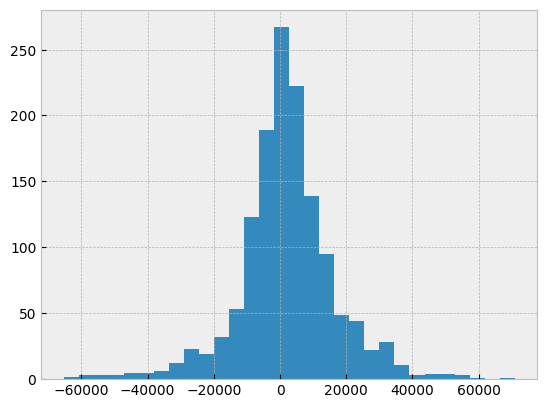

In [14]:
df_results.query('Exist_Fuel_Type == 4').NPV.hist(bins=30)
#xlim(-10000, 10000)

In [ ]:
# Make a Break-even rule for use in multiple charts
rule_data = pd.DataFrame([{"ThresholdValue": 0, "Threshold": "breakeven"}])
rule = alt.Chart(rule_data).mark_rule(color='green').encode(
    x=alt.X('ThresholdValue', axis=alt.Axis(title='Net Present Value')),
    size=alt.value(2)
)

In [ ]:
# Function to limit values in a Pandas Series to +/- some limit
def limit_vals(a_series, limit_value):
    """Returns an array that limits the values in the Pandas Series
    'a_sereies' to +/- 'limit_value'.
    """
    return np.where(
        a_series.abs() < limit_value, 
        a_series,
        limit_value * np.sign(a_series)
    )

In [ ]:
limit = 50000
df_results['npv_limited'] = limit_vals(df_results.NPV, limit)
main = alt.Chart(df_results, height=120).mark_point().encode(
    y=alt.Y('Exist_Fuel', axis=alt.Axis(title='Existing Fuel Type')),
    x=alt.X('npv_limited', bin=alt.Bin(maxbins=60), scale=alt.Scale(domain=(-limit, limit))),
    size=alt.Size('count()', legend=None)
)
rule + main

In [ ]:
econ_color_scale = alt.Scale(
            domain=['Economic', 'Close', 'Not Economic'],
            range=['green', '#FFBB00', 'red'])

# Make an 'econ_order' field to sort the stacking of the bars
econ_order = {'Economic': 1, 'Close': 2, 'Not Economic': 3}
df_results['econ_order'] = df_results.Econ.map(econ_order)

cht = alt.Chart(df_results).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y=alt.Y('Exist_Fuel', axis=alt.Axis(title='Existing Fuel Type')),
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/by_fuel.png', scale_factor=1.5)
cht

In [ ]:
pd.pivot_table(
    df_results, 
    values='City', 
    index='Econ', 
    columns='Exist_Fuel', 
    aggfunc='count',
    margins=True
)

In [ ]:
df_results.query('Exist_Fuel == "Electricity" and Econ == "Close"')

In [ ]:
df_results.query('Exist_Fuel == "Natural Gas" and Econ == "Close"')

In [ ]:
df_results.query('Exist_Fuel == "Natural Gas"')['City'].unique()

In [ ]:
main = alt.Chart(df_results).mark_bar().encode(
    x=alt.X('NPV', bin=alt.Bin(maxbins=60), axis=alt.Axis(title='Net Present Value')),
    y='count()',
    row='Exist_Fuel',
)
#(main + rule).facet(
#    column='Exist_Fuel'
#)

# Uncomment below to see chart, but not great
# main

In [ ]:
main = alt.Chart(df_results.query('Exist_Fuel_Type == 2')).mark_point().encode(
    y='Exist_Fuel',
    x=alt.X('NPV', bin=alt.Bin(maxbins=60)),
    size=alt.Size('count()', legend=None)
)
rule + main

In [ ]:
main = alt.Chart(df_results.query('Exist_Fuel_Type == 4')).mark_point().encode(
    y='Scenario',
    x=alt.X('NPV', bin=alt.Bin(maxbins=60)),
    size=alt.Size('count()', legend=None)
)
rule + main

In [ ]:
# Some data subsets, oil only
df_oil = df_results.query('Exist_Fuel_Type == 4').copy()
df_oil_pce = df_results.query('Exist_Fuel_Type == 4 and PCE > 0.0')
df_oil_no_pce = df_results.query('Exist_Fuel_Type == 4 and PCE == 0.0')

# PCE Communities
cht = alt.Chart(df_oil_pce).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y='Scenario',
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/pce_scenarios.png', scale_factor=1.5)
cht

In [ ]:
# Non-PCE Communities
cht = alt.Chart(df_oil_no_pce).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y='Scenario',
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/non_pce_scenarios.png', scale_factor=1.5)
cht

In [ ]:
# Econ split by Census Area, oil only
cht = alt.Chart(df_oil).mark_bar().encode(
    x=alt.X('count(Econ)', stack='normalize', axis=alt.Axis(title='Fraction of Cases Modeled')),
    y=alt.Y('Census_Area', axis=alt.Axis(title='Census Area')),
    color=alt.Color('Econ', scale=econ_color_scale),
    order='econ_order',
)
cht.save('images/by_census_area.png', scale_factor=1.5)
cht

In [ ]:
df_oil.groupby('Census_Area')[[
    'Elec_Rate_Incremental', 
    'Fuel_Price_Incremental',
    'COP',
    'PCE',
    'Elec_Use_Jan',
]].mean()

## Plotting of All Cases Run

In [ ]:
areas = sorted(lib.df_city.census_area.unique())
' '.join(areas)

In [ ]:
# Make a Symbol Scale so that the same symbol is used for
# each scenario.  Found that in Census areas that didn't have
# any PCE, different symbols were being used for the Small and Large
# Load scenarios than in PCE census areas.
scenario_symbol_scale = alt.Scale(
            domain=['Base', 'Large Load', 'Small Load', 'Low Elec', 'Community Bldg', 'No PCE'],
            range=['circle', 'square', 'triangle-up', 'cross', 'diamond', 'triangle-right'])


In [ ]:
npv_limit = 20000.
df_oil['npv_limited'] = limit_vals(df_oil.NPV, npv_limit)
for ca in cen_areas:
    print(ca)
    df_ca = df_oil.query('Census_Area == @ca')
    main = alt.Chart(df_ca).mark_point(
        size=150, opacity=0.7, stroke='black', strokeWidth=1
    ).encode(
        x=alt.X('npv_limited', axis=alt.Axis(title='Net Present Value', grid=False), scale=alt.Scale(domain=(-npv_limit, npv_limit))),
        y=alt.Y('City', axis=alt.Axis(title='Community', grid=True)),
        shape=alt.Shape('Scenario', scale=scenario_symbol_scale),
        color=alt.Color('Econ', scale=econ_color_scale),
        fill=alt.Color('Econ', scale=econ_color_scale),
        #tooltip=['Scenario']
    )
    (rule + main).save(f'images/census_area/{ca}.png', scale_factor=1.5)

## Analysis of Other Results

### Design Heating Temperature

In [ ]:
city_temp = list(set(zip(df_oil.City, df_oil.Design_Heat_Temp)))
df_dt = pd.DataFrame(city_temp, columns=['City', 'Design_Heat_Temp'])
df_dt.head()

In [ ]:
df_dt.Design_Heat_Temp.hist(bins=30)

In [ ]:
alt.Chart(df_dt).mark_point().encode(
    x=alt.X('Design_Heat_Temp', bin=alt.Bin(maxbins=40)),
    size=alt.Size('count()', legend=None)
)

### % of Heating Load Served by Heat Pump

In [ ]:
df_oil.HP_Load_Frac.hist(bins=30)

## Analysis of Seasonal COP

In [ ]:
rcParams['font.size'] = 12.5            # set Font size in Chart

In [ ]:
df_oil.query('Scenario == "Base"').plot(x='Design_Heat_Temp', y='COP', kind='scatter')
xlabel('Design Heating Temperature of Community, °F')
ylabel('Seasonal COP')
gcf().set_size_inches((8,5))
tight_layout()
savefig('images/seasonal_cop.png')

In [ ]:
# COP Curve at any outdoor tempreature

from heatpump.home_heat_model import HomeHeatModel
# Use the curve from the Heat Pump Calculator
def cops_for_temps(temps, hspf):
    """Returns a numpy array of COPs for the associated array of 
    outdoor temperatures, passed in as 'temps'.  Calculates the 
    COPs for a heat pump with HSPF of 'hspf'.
    """
    cops = np.interp(temps, HomeHeatModel.TEMPS_FIT, HomeHeatModel.COPS_FIT)
    # my judgement on the 0.5 exponent; theory would say 1.0
    cops *= (hspf / HomeHeatModel.BASE_HSPF) ** 0.5
    return cops

# Test points to see if they match.  This is at Base HSPF
cops_for_temps([10.8, 34.5, 40], 11.33)

In [ ]:
temps = np.linspace(-10, 50)
cops_10 = cops_for_temps(temps, 10.)
cops_12 = cops_for_temps(temps, 12.)
cops_14 = cops_for_temps(temps, 14.)
plot(temps, cops_10)
plot(temps, cops_12)
plot(temps, cops_14)
text(50.5, cops_10[-1], 'HSPF = 10', verticalalignment='center')
text(50.5, cops_12[-1], 'HSPF = 12', verticalalignment='center')
text(50.5, cops_14[-1], 'HSPF = 14', verticalalignment='center')
xlim(-10, 60)
xlabel('Outdoor Temperature, °F')
ylabel('COP')
gcf().set_size_inches((8,5))
tight_layout()
savefig('images/cop_vs_outdoor.png')